# 핸즈온 머신러닝

## 챕터 04

### 모델 훈련

In [1]:
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.family'] = 'Arial Unicode MS'
matplotlib.rcParams['axes.unicode_minus'] = False
# 한글 폰트 지정 후 그래프에서 마이너스 폰트 깨지는 문제 해결

In [2]:
# 선형 회귀
# - 경사 하강법(반복적인 최적화 방식) : 모델 파라미터를 조금씩 바꾸면서 비용함수를 훈련 세트에 대해 최소화 시킴.
# cf. 다항 휘귀(비선형 데이터셋) : 파라미터가 많아서 과대적합되기 쉽다. -> 학습 곡선을 사용해 과대적합 감지하자.

# 모델 훈련이란?
# : 모델이 훈련 세트에 가장 잘 맞도록 모델 파라미터를 설정하는 것
# 회귀에 가장 널리 사용되는 측정지표 : 평균 제곱근 오차(RMSE) -> 최소화해야.

In [5]:
# 정규 방정식
# : 비용함수를 최소화하는 세타값을 찾기 위한 해석적인 방법
#   수학 공식

# 선형처럼 보이는 데이터
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [8]:
# 그림을 저장할 위치
import os

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


그림 저장: generated_data_plot


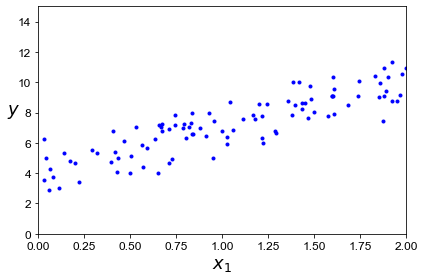

In [9]:
# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [10]:
# inv()
# : 역행렬 계산

# dot()
# : 행렬 곱셈

X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.08343875],
       [3.01232637]])

In [12]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.08343875],
       [10.1080915 ]])

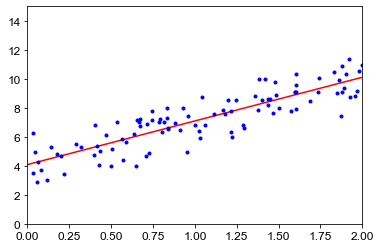

In [13]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0,2,0,15])
plt.show()

In [15]:
# 선형 회귀 수행
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [17]:
# intercept_ : 편향
# coef_ : 가중치
lin_reg.intercept_, lin_reg.coef_

(array([4.08343875]), array([[3.01232637]]))

In [18]:
lin_reg.predict(X_new)

array([[ 4.08343875],
       [10.1080915 ]])

In [19]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.08343875],
       [3.01232637]])

In [20]:
np.linalg.pinv(X_b).dot(y)

array([[4.08343875],
       [3.01232637]])

#### 경사 하강법

In [21]:
# 경사 하강법(gradient descent-GD)
# : 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정해가는 것
#  그레이디언트가 감소하는 방향으로 진행 -> 그레이디언트가 0이 되면 최솟값에 도달한 것!
#  한 번에 조금씩 비용 함수가 감소되는 방향으로 진행 -> 최솟값에 수렴할 때까지 점진적으로 향상.

# 스텝의 크기가 중요! -> 학습률 하이퍼파라미터
# 1)학습률이 너무 작으면 알고리즘이 수렴하기 위해 반복을 많이 진행 -> 시간 너무 오래 걸림.
# 2)학습률이 너무 크면 골짜기를 가로질러 반대편으로 우왕좌왕하기 때문에, 이전보다 더 높은 곳(우리는 최솟값을 찾아야한다.)으로 갈 수 있다.
#   이는 알고리즘을 더 큰 값으로 발산하게 만들어 최솟값을 못 찾을 수도 있다.

# 매끈하지 않은 비용 함수
# 1) 왼쪽에서 시작 -> 전역 최솟값보다 덜 좋은 지역 최솟값에 수렴
# 2) 오른쪽에서 시작 -> 평탄한 지역을 지나기 위해 시간이 너무 오래, 일찍 멈춰서 최솟값에 도달x.

# 선형 회귀를 위한 MSE 비용 함수
# : 볼록 함수 - U (어떤 두 점을 선택해 선을 그어도 곡선을 가로지르지 않는)
# : 연속된 함수
# : 기울기가 갑자기 변하지 않는다.
# >>> 충분한 시간이 주어지면, 경사 하강법이 전역 최솟값에 가까이 접근 가능.

In [22]:
# 모델의 파라미터 공간에서 찾는다.
# -> 모델 훈련이 비용 함수를 최소화하는 모델 파라미터늬 조합을 파라미터 공간에서 찾는다.
# : 파라미터 많. 차원 커짐. 검색 더 어려워.

In [24]:
# 배치 경사 하강법
# : 매 경사 하강법 스텝에서 전체 훈련 세트에 대해 계산.
#   -> 매 스텝에서 훈련 데이터 전체를 사용한다는 의미.
eta = 0.1 # 학습률
n_iterations = 1000
m = 100

theta = np.random.rand(2,1) # 무작위 초기화
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
theta

array([[4.08343875],
       [3.01232637]])

In [25]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

그림 저장: gradient_descent_plot


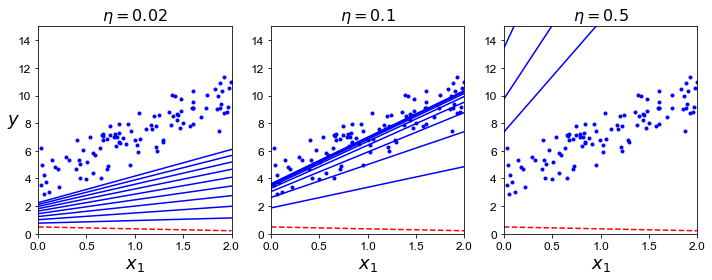

In [26]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

# >>> 빨간 점선부터 위로 간다.
# 0.02 : 학습률이 너무 낮. -> 최적점에 도달하겠지만 시간이 너무 오래 걸림.
# 0.1 : 학습률이 적당. 반복 몇 번만에 최적점에 수렴
# 0.5 : 알고리즘이 이리저리 널뛰면서 점점 발산

#### 확률적 경사 하강법

In [27]:
# 확률적 경사 하강법

# 배치 경사 하강법의 문제 : 매 스텝에서 전체 훈련세트를 사용
# >>> 훈련 세트 커지면, 속도가 느려짐.

# 확률적 경사 하강법 : 매 스텝에서 한 개의 샘플을 무작위로 선택. 하나의 샘플에 대한 그레이디언트를 계산
# -> 매 반복에서 다룰 데이터가 매우 적다 -> 속도 빠름. (매우 큰 데이터셋도 훈련 가능.)
# but, 확률적(무작위)이기 때문에 훨씬 불안정.
# 비용함수가 서서히 부드럽게 감소하는 것이 아니라 -> 위아래로 요동치며 평균적으로 감소(최솟값에 안착 못하고 전역 최솟값을 찾을 가능성 높다.)
# 최솟값에 수렴x -> 최적치가x.
# => 해결 방법: 학습률을 점직적으로 감소시키는 것.(시작 시 학습률 크게, 이후 점차 작게 줄여.)
# 학습 스케줄: 매 반복에서 학습률을 결정하는 함수
# + 학습률이 너무 빨리 줄어들면, 지역 최솟값에 갇히거나 중간에 멈춘다.
# + 학습률이 너무 천천히 줄어들면, 오랫동안 최솟값 주변을 머무르거나, 훈련을 너무 일찍 중지 -> 지역 최솟값에 수렴.

In [31]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

[[4.01747874]
 [3.04638283]]
그림 저장: sgd_plot


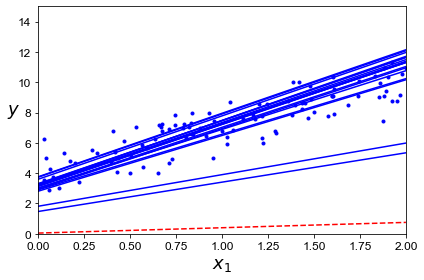

In [35]:
# 학습 스케줄을 사용한 확률적 경사 하강법
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

# m : 훈련 세트에 있는 샘플 수
theta = np.random.rand(2,1)
for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # 책에는 없음
            y_predict = X_new_b.dot(theta)           # 책에는 없음
            style = "b-" if i > 0 else "r--"         # 책에는 없음
            plt.plot(X_new, y_predict, style)        # 책에는 없음
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index +1]
        yi = y[random_index:random_index +1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # 책에는 없음
        
print(theta)
plt.plot(X, y, "b.")                                 # 책에는 없음
plt.xlabel("$x_1$", fontsize=18)                     # 책에는 없음
plt.ylabel("$y$", rotation=0, fontsize=18)           # 책에는 없음
plt.axis([0, 2, 0, 15])                              # 책에는 없음
save_fig("sgd_plot")                                 # 책에는 없음
plt.show()                                           # 책에는 없음

In [36]:
# SGD 방식의 선형 회귀
# SGDRegressor
# max_iter=1000 : 최대 1,000번 에포크 동안 실행
# tol=le-3 : 한 에포크에서 0.001보다 적게 손실이 줄어들 때까지 실행
# eta0=0.1 : 학습률 0.1
# penalty=None : 규제 없음.
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [38]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.0950447]), array([3.01745082]))

#### 미니배치 경사 하강법

그림 저장: gradient_descent_paths_plot


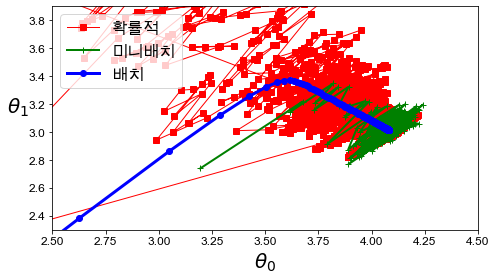

In [42]:
# 미니배치 경사 하강법
# : 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그레이디언트를 계산하는 방식
# GPU 사용 (성능 향상)
# 미니배치를 어느정도 크게 하면, 덜 불규칙하게 움직인다.
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)
        
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="확률적")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="미니배치")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="배치")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

# >>> 확률적 & 비니배치 경사 하강법 : 적절한 학습 스케줄 사용 시 최솟값에 도달 가능하다.

#### 다항 회귀

그림 저장: quadratic_data_plot


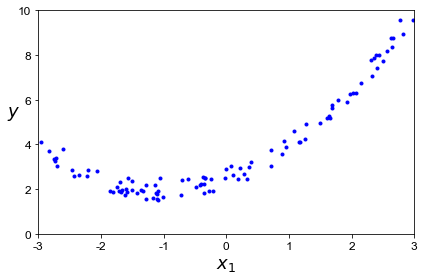

In [45]:
# 다항 회귀(polynomial regression)
# : 비선형 데이터를 학습하는 데 선형 모델 사용 가능.
#   각 특성의 거듭제곱을 새로운 특성으로 추가, 해당 특성을 포함한 데이터셋에 선형 모델 훈련시키는 방법.

# 비선형 데이터 생성
m = 100
X = 6 * np.random.rand(m,1) -3
y = 0.5 * X**2 + X + 2 + np.random.rand(m,1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [47]:
# 훈련 세트의 각 특성을 제곱해서 새로운 특성으로 추가
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

[2.62265367]
[2.62265367 6.87831227]


In [48]:
# LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.45899717]), array([[1.00986244, 0.48766742]]))

그림 저장: quadratic_predictions_plot


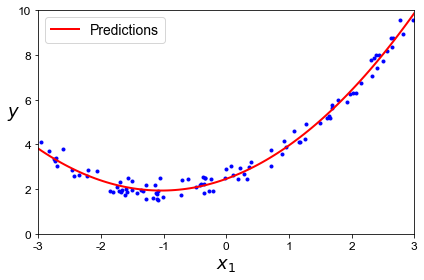

In [49]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

#### 학습 곡선

In [73]:
# 학습 곡선
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # 책에는 없음
    plt.xlabel("Training set size", fontsize=14) # 책에는 없음
    plt.ylabel("RMSE", fontsize=14)              # 책에는 없음

그림 저장: underfitting_learning_curves_plot


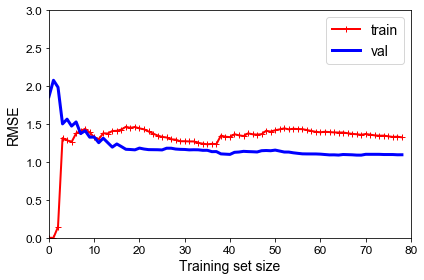

In [74]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # 책에는 없음
save_fig("underfitting_learning_curves_plot")   # 책에는 없음
plt.show()                                      # 책에는 없음

# >>> 과소적합
# : 훈련세트 -> 샘플이 추가될수록 잡음도 있고 비선형, 모델의 완벽 학습은 불가능. 훈련세트에 샘플 추가되어도 평균 오차 크게 변화 없다.
# : 검증세트 -> 적은 수의 훈련 샘플로 훈련될 때는 제대로 일반화 될 수 없다, 검증 오차가 초기에 크다. 모델링에 실패해서 점점 훈련세트와 비슷해짐.

그림 저장: learning_curves_plot


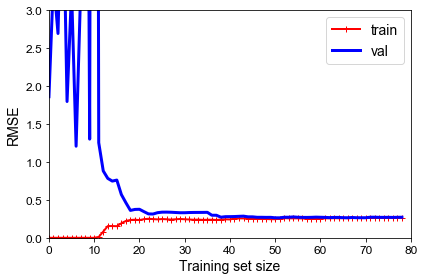

In [79]:
# 10차 다항 회귀 모델의 학습 곡선
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # 책에는 없음
save_fig("learning_curves_plot")  # 책에는 없음
plt.show()                        # 책에는 없음

In [ ]:
# 편향/분산 트레이드오프
# 모델의 일반화 오차 -> 세 가지 다른 종류의 오차의 합으로 표현 가능.
# 1) 편향
#   : 잘못된 가정이 원인. 과소적합 주의
# 2) 분산
#   : 훈련 데이터셋의 작은 변동이 모델에 민감한 것이 원인. 과대적합 주의
# 3) 줄일 수 없는 오차
#   : 잡음이 원인, 잡음 제거 -> 오차 줄임.

# >>> 자유도 높은 모델일수록 분산이 높다.
# >>> 모델 복잡도가 높 -> 분산 높 & 편향 낮
# >>> 모델 복잡도가 낮 -> 분산 낮 & 편향 높

In [83]:
# 규제가 있는 선형 모델
# 과대적합 감소 방법 : 모델 규제.

# 선형 회귀 모델의 규제 -> 모델의 가중치 제한
# 릿지회귀, 라쏘회귀, 엘라스틱넷

# 1) 릿지회귀(ridge)
# : 규제가 추가된 선형 회귀 버전
#   규제항이 비용함수에 추가.
#   훈련 종료 시, 모델의 성능을 규제가 없는 성능 지표로 평가.
# 알파=0 이면 릿지회귀 = 선형회귀
# 알파가 아주 크면 가중치가 거의 0에 가까워짐.
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.47012687]])

In [84]:
# 2) 라쏘회귀(lasso - least absolute shrinkage and selection operator)
# : 선형 회귀의 또 다른 규제된 버전
#   비용 함수에 규제항을 더하지만, 가중치 벡터 l1 노름 사용.
#   덜 중요한 가중치를 제거하려고 한다.
#   자동으로 특성을 선택하고 희소 모델을 만든다.
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.42094769])

In [85]:
# 3) 엘라스틱넷(elastic net)
# : 릿지회귀와 라쏘회귀의 절충 모델
#   규제항 = 릿지의 규제항 + 라쏘의 규제항
#   혼합 정도 : 혼합 비율 r을 사용해 조절.
#   r=0 이면 엘라스틱넷 = 릿지회귀
#   r=1 이면 엘라스틱넷 = 라쏘휘귀
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5) # l1_ratio : 혼합 비율 r
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

# >>> 일반적으로 릿지회귀가 기본 모델, but 특성이 작다고(몇 개뿐) 의심되면 라쏘 혹은 엘라스틱넷 회귀 사용.
# >>> 특성 수 > 훈렴 샘플수 혹은 특성 몇 개가 강하게 연관돼있으면 엘라스틱넷 선호.(라쏘는 문제를 일으킴)

array([5.41976747])

In [88]:
# 조기 종료
# : 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것
#   훌륭한 공짜 점심
# SGDRegressor의 매개변수 warm_start=True -> fit()메서드 호출 시 처음부터 다시시작 하지 않고 이전 모델에서 파라미터 훈련을 이어간다.

#### 로지스틱 회귀

그림 저장: logistic_function_plot


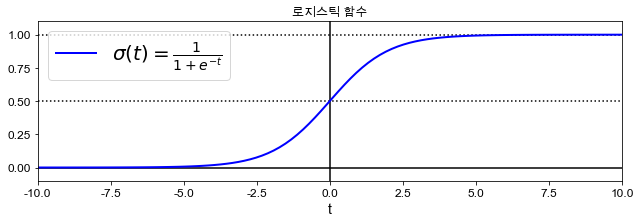

In [90]:
# 로지스틱 회귀(logistic regressoin)
# : 샘플이 특성 클래스에 속할 확률을 추정하는 데 사용
#   분류에서 사용
#   이진 분류기(레이블1: 양성 클래스 / 레이블2: 음성 클래스)
# 입력 특성의 가중치 합을 계산하고 편향을 더한다.
# 선형 회귀처럼 바로 결과를 출력하는 대신에, 결괏값의 로지스틱을 출력
# 로지스틱: 0 - 1 사이의 값을 출력하는 시그모이드 함수(s자 형태)

t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.title("로지스틱 함수")
plt.show()

In [91]:
# 결정 경계
# 붓꽃 데이터 셋
# : 세 개의 품종(0,1,2)과 꽃잎&꽃받침의 너비와 길이를 담고 있는 데이터셋.

# 꽃잎 너비를 기반으로 Iris-Versicolor([1])종을 감지하는 분류기
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [94]:
X = iris["data"][:, 3:] # 꽃잎의 너비
y = (iris["target"] == 2).astype(np.int64) # Iris-Versicolor 면 1, 아니면 0 반환.

In [95]:
# 로지스틱 회귀 모델 훈련
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

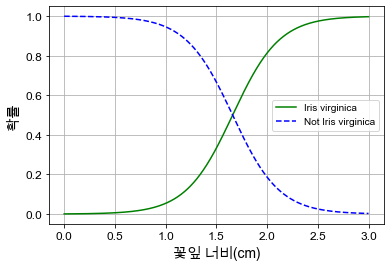

In [103]:
# 꽃잎 너비 0~3cm의 꽃 추정 확률 계산
# predict_proba() : 확률 반환
# predic() : 클래스 레이블을 반환
X_new = np.linspace(0,3,1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")
plt.xlabel("꽃잎 너비(cm)")
plt.ylabel("확률")
plt.legend()
plt.grid(True)
plt.show()

In [104]:
log_reg.predict([[1.7], [1.5]])
# 1.7cm -> 1 -> Iris-verginica 맞다.
# 1.5cm -> 0 -> Iris-verginica 아니다.

array([1, 0])

<ipython-input-106-b8c2ccdceb57>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int)


그림 저장: logistic_regression_contour_plot


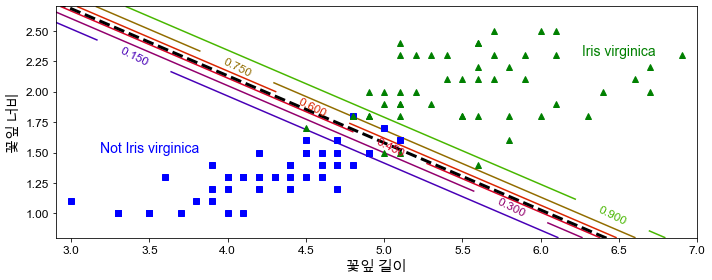

In [106]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("꽃잎 길이", fontsize=14)
plt.ylabel("꽃잎 너비", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

In [107]:
# 소프트맥스 회귀
# : 여러 개의 이진 분류기를 연결하지 않고 직접 다중 클래스를 지원하도록 하는 것
#   로지스틱 회귀도 소프트맥스 회귀에 속한다.
# 한 번에 하나의 클래스만 예측(다중 클래스는 맞지만, 다중 출력은 아니다.)
# 상호 배타적인 클래스에서만 사용해야.
# 크로스 엔트로피 비용 함수를 최소화하는 것이 부합한다.
# multi_class="multinomial" : 소프트맥스 회귀 사용 매개변수 설정
X = iris["data"][:, (2,3)]
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [108]:
softmax_reg.predict([[5,2]]) # [2] : Iris-Viginica

array([2])

In [109]:
softmax_reg.predict_proba([[5,2]]) # [0]: 63%, [1]: 57%, [2]일 확률: 94%

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

## 챕터 05

### 서포트 벡터 머신

#### 선형 SVM 분류

In [111]:
# SVM(support vector machine)
# : 매우 강력, 다목적 머신러닝 모델
#   복잡한 분류 문제에 잘 들어맞고, 작거나 중간 크기의 데이터셋에 적합.
#   특성의 스케일에 민감
#   -> StandradScaler를 사용하여 결정 경계 조정.
# 선형 svm 분류
# 결정 경계가 샘플에 너무 가까우면 새로운 샘플에 대해서는 잘 작동 못 할 수도 있다.
# 서포트 벡터 : 도로 경계에 위치한 샘플

# 소프트 마진 분류
# cf.하드 마진 분류
# : 모든 샘플이 도로 바깥쪽에 올바르게 분류.
#   이상치에 민감.
#   데이터가 선형적으로 구분되어야 제대로 작동.
#   => 좀 더 유연한 모델 필요 -> 소프트 마진 분류(도로 폭을 가능한 넓게 유지하는 것과 마진 오류 사이에 적절한 균형을 잡는 것)
# 마진 오류 : 샘플이 도로 중간이나 바깥쪽에 있는 경우

# >>> 과대적합이면, C는 낮게 설정하여 규제를 올리자.
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2,3)]
y = (iris["target"] == 2).astype(np.float64)

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge")),
])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

In [112]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

In [114]:
# LinearSVC 클래스 -> 선형 커널을 사용하는 SVC 클래스로 대체 가능
# SVC(kernel="linear", C=1)
# SDGClassifier(loss="hinge", alpha=1/(m*C))

In [122]:
# 비선형 SVM 분류 
# : 특성을 더 추가해서 선형적으로 구분되는 데이터셋을 만들자

# Pipeline = PolynomialFeatures변환기 + StandardScaler, LinearSVC
# 이진 분류를 위한 작은 데이터셋 moons사용
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15)
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("scm_clf", LinearSVC(C=10, loss="hinge"))
])

polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('scm_clf', LinearSVC(C=10, loss='hinge'))])

In [124]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)


그림 저장: moons_polynomial_svc_plot


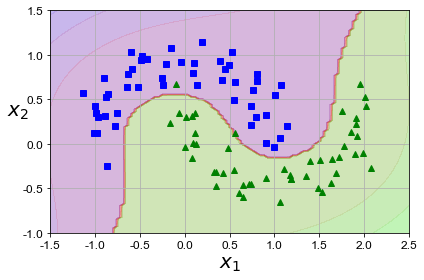

In [125]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

In [127]:
# 다항식 커널
# 낮은 차수의 다항식 : 매우 복잡한 데이터셋을 잘 표현 못함
# 높은 차수의 다항식 : 모델을 느리게 만듦(굉장히 많은 특성을 추가하기 때문)
# 커널 트릭 : 실제로는 특성을 추가하지 않으면서 다항식 특성을 많이 추가한 것과 같은 결과를 얻을 수 있다.
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("scm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
# degree=3 : 3차 다항식 커널
# coef0=1 : 모델이 얼마나 영향을 받을지 설정(기본값=0)
# C=5 : 규제
])

poly_kernel_svm_clf.fit(X, y)

# 과대적합 : 다항식 차수, gamma, C 감소
# 과소적합 : 다항식 차수, gamma, C 증가

# >>> 여러가지 커널 중 언제나 선형 커널을 먼저 시도해보자
# >>> LinearSVC 가 SVC(kernal="linear")보다 훨씬 빠르다.

Pipeline(steps=[('scaler', StandardScaler()),
                ('scm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [129]:
# SVM 회귀
# LinearSVR : 선형SVM 회귀
# LinearSVR 을 사용해 만든 선형 SVM 회귀
# 훈련 데이터의 스케일을 맞추고, 평균을 0으로
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5) # epsilon=1.5 : 도로폭 1.5
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5)

In [130]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')